# Data prep
- load A
- load C
- (optional) check coin list from coingecko

In [31]:
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
plt.style.use(matplotx.styles.dracula)
import numpy as np

In [32]:
from config.query import BigQueryClient
from config.config import TABLES
bq = BigQueryClient()
A = bq.get_dataframe(TABLES['A'])

In [2]:
import duckdb
import pandas as pd

# Establish a connection to the local Parquet file
conn = duckdb.connect(database=':memory:', read_only=False)

PCT = 0.03

# Query to load the first 10% of the rows from the Parquet file
query = f"""
SELECT *
FROM 'C.parquet'
LIMIT (SELECT CAST({PCT} * COUNT(*) AS INTEGER) FROM 'C.parquet')
"""

# Execute the query and load the result into a DataFrame
C = conn.execute(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [2]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
cg = CoinGeckoAPI()
coin_markets = cg.get_coins_markets(vs_currency='usd')
df_market_data = pd.DataFrame(coin_markets)
df_market_data = df_market_data[['id', 'symbol', 'name', 'current_price', 'market_cap', 'total_volume']]
df_market_data_sorted = df_market_data.sort_values(by='market_cap', ascending=False)
protocol_gecko = df_market_data_sorted['id']

# Get a mapping from A
- this maps the coin name to the coin id

In [68]:
import json

rev_map = {}

for idx, row in A.iterrows():
    if pd.notna(row['assetToken']) and row['assetToken'] != "-":
        rev_map[row['assetToken']] = str(idx)
    if pd.notna(row['symbol']) and row['symbol'] != "-":
        rev_map[row['symbol']] = str(idx)

with open('config/rev_map.json', 'w') as json_file:
    # Use json.dump() to write the rev_map dictionary to the file
    json.dump(rev_map, json_file, indent=4)

# Sort C into 4 categories, whether 'token_name' can be found in:
- rev_map
    - this is the easiest case, we can just use the coin id from the mapping
- LP
    - need to think more, might need to consider bridge
- UNKNOWN
    - a common cell here is UNKNOWN (heco:0x5eE41aB6edd38cDfB9f6B4e6Cf7F75c87E170d98)
    - this follows UNKNOWN (X:Y)
    - the X:Y mapping identifies Y as the search source, we utilize Y to find the protocol id
- Other
    - major custodial protocols, need to be handled manually



In [69]:
df = C.copy()

# Initialize a dictionary to hold categorized DataFrames
categories = {'rev_map': None, 'LP': None, 'UNKNOWN': None, 'Other': None}

# Categorize tokens
categories['rev_map'] = df[df['token_name'].isin(rev_map.keys())]
categories['LP'] = df[df['token_name'].str.contains('LP') & ~df['token_name'].isin(rev_map.keys())]
categories['UNKNOWN'] = df[df['token_name'].str.contains('UNKNOWN') & ~df['token_name'].isin(rev_map.keys())]
categories['Other'] = df[~df['token_name'].str.contains('LP|UNKNOWN') & ~df['token_name'].isin(rev_map.keys())]

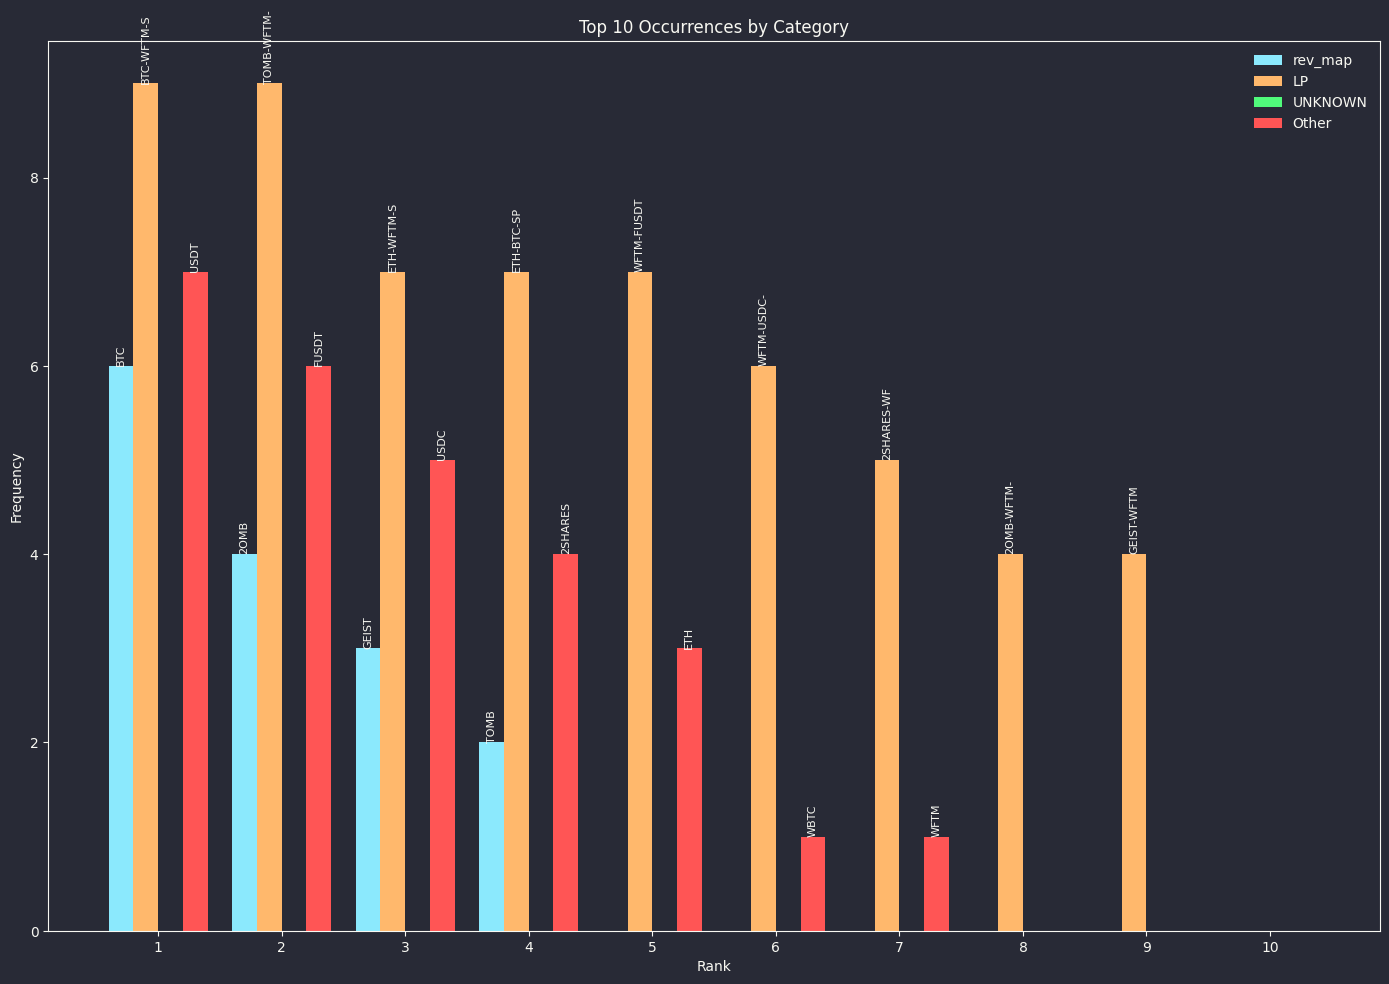

In [70]:
# Prepare data for combined bar chart
data = {
    'Rank': range(1, 11),  # 1st to 10th place
}


max_length = 10  # Maximum length for each category

protocol_names = {category: df_cat['token_name'].value_counts().head(max_length).index.tolist() for category, df_cat in categories.items()}

for category, df_cat in categories.items():
    top_occurrences = df_cat['token_name'].value_counts().head(max_length)
    # Pad the values list with zeros (or np.nan) if it's shorter than max_length
    padded_values = np.pad(top_occurrences.values, (0, max_length - len(top_occurrences.values)), 'constant', constant_values=(0))
    data[category] = padded_values

# Convert dictionary to DataFrame
combined_df = pd.DataFrame(data).set_index('Rank')

# Plotting
fig, ax = plt.subplots(figsize=(14, 10))
width = 0.2  # Width of the bars

# Generate positions for each group of bars
positions = np.arange(1, 11)

# Plot each category and add protocol names as annotations
for i, (category, values) in enumerate(combined_df.items()):
    bars = ax.bar(positions + i * width, values, width, label=category)
    for bar, protocol_name in zip(bars, protocol_names[category]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), protocol_name[:10], 
                ha='center', va='bottom', fontsize=8, rotation=90)

# Customization
ax.set_xlabel('Rank')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Occurrences by Category')
ax.set_xticks(positions + width * 1.5)
ax.set_xticklabels(combined_df.index)
ax.legend()

plt.tight_layout()
plt.show()

# Process the 4 categories

## rev_map

In [8]:
categories['rev_map']['token_name'] = categories['rev_map']['token_name'].map(rev_map)

/var/folders/f0/djj7fhr557g00t074rkmzmrr0000gn/T/ipykernel_45190/3745815436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories['rev_map']['token_name'] = categories['rev_map']['token_name'].map(rev_map)


## UNKNOWN

In [10]:
import re
unique_token_names = categories['UNKNOWN']['token_name'].unique()
eth_address_pattern = re.compile(r'0x[a-fA-F0-9]{40}')
unique_addresses_list = list({match for name in unique_token_names 
                              for match in eth_address_pattern.findall(str(name))})

address_to_id_mapping = {address: A.loc[A['address'].str.contains(address, na=False), 'id'].iloc[0] 
                         for address in unique_addresses_list
                         if A['address'].str.contains(address, na=False).any()}

categories['UNKNOWN'] = categories['UNKNOWN'][categories['UNKNOWN']['token_name'].apply(lambda x: any(match in address_to_id_mapping for match in eth_address_pattern.findall(str(x))))]
categories['UNKNOWN']['token_name'] = categories['UNKNOWN']['token_name'].apply(lambda x: next((address_to_id_mapping[match] for match in eth_address_pattern.findall(str(x)) if match in address_to_id_mapping), "Not Found"))

KeyError: 'token_name'

## Other

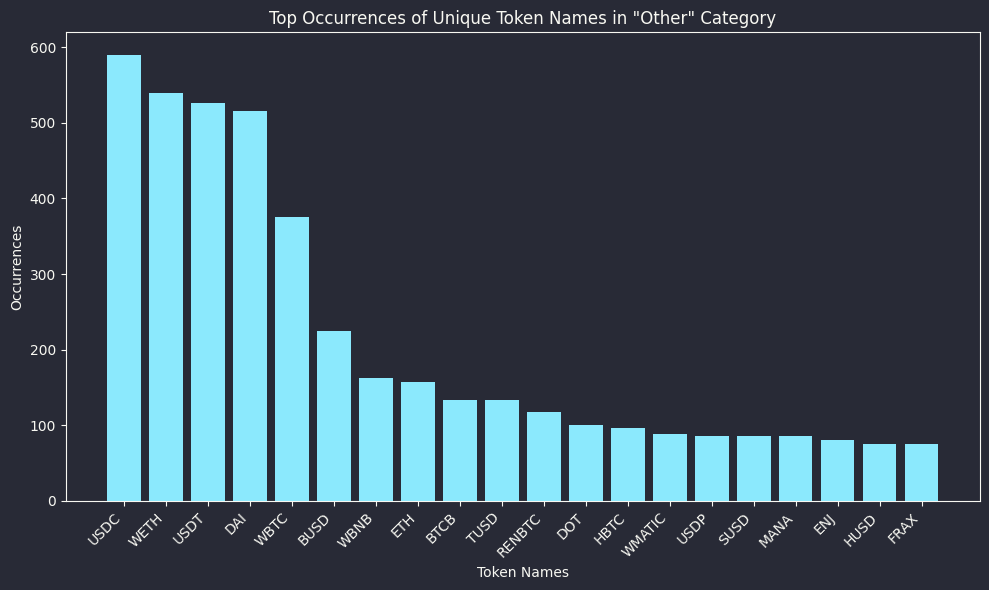

In [14]:
token_name_counts = categories['Other']['token_name'].value_counts()
top_n = 20
top_token_names = token_name_counts.head(top_n).index
top_counts = token_name_counts.head(top_n).values

plt.figure(figsize=(10, 6))
plt.bar(top_token_names, top_counts)
plt.xlabel('Token Names')
plt.ylabel('Occurrences')
plt.title('Top Occurrences of Unique Token Names in "Other" Category')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [15]:
x = top_token_names

x = ['FRAX']
def search_and_display_keyword(df, keyword):
    # Search for the keyword in all columns of DataFrame 'A'
    mask = df.apply(lambda x: x.astype(str).str.contains(keyword, case=False, na=False)).any(axis=1)
    filtered_df = df[mask]
    print(keyword)
    if not filtered_df.empty:
        print("Found in rows:")
        print(filtered_df[['name', 'id']])
        display(filtered_df)
    else:
        print(f"No results found for keyword: {keyword}")


for i in x:
    search_and_display_keyword(A, i)

FRAX
Found in rows:
                  name    id
252          Frax Swap  2121
558       Koyo Finance  1766
833     Asgard Finance   476
1049          Fraxlend  2076
1104       Ape Finance  2183
1437        XUSD Money  1080
1439          Frax FPI  2607
1541        Frax Ether  2221
1807         handle.fi   724
1821      Iron Finance   352
2289  Resonate Finance  3130
2532            ZooDAO  2927
2950            Argano  1221
3068              Frax   359
3082           Blindex  1528


,address,assetToken,audit_links,audit_note,audits,category,chain,chains,cmcId,currentChainTvls,...,referralUrl,rugged,stablecoins,symbol,treasury,twitter,url,wrongLiquidity,group,type
252,None,None,None,None,0.0,Dexes,Ethereum,"[Moonbeam, Binance, Dogechain, Ethereum, Avala...",None,"{'Moonbeam': 1185483.2449, 'Binance': 1061643....",...,None,<NA>,None,-,None,fraxfinance,https://app.frax.finance/swap/main,<NA>,Trading & Exchanges,Trading & Exchanges
558,boba:0x618CC6549ddf12de637d46CDDadaFC0C2951131C,None,None,None,0.0,Dexes,Boba,[Boba],None,"{'Boba': 1119.3682, 'Boba-staking': 0, 'stakin...",...,None,<NA>,None,KYO,koyo.js,KoyoFinance,https://koyo.finance,<NA>,Trading & Exchanges,Trading & Exchanges
833,0x0dc5189ec8cde5732a01f0f592e927b304370551,None,None,None,0.0,Yield,Ethereum,[Ethereum],4236,"{'Ethereum': 0, 'Ethereum-staking': 0, 'stakin...",...,None,<NA>,None,ASG,None,AsgardDAO,https://www.asgarddao.finance,<NA>,Asset Management,Asset Management
1049,None,None,None,None,0.0,Lending,Ethereum,[Ethereum],None,"{'Ethereum': 132402416.68435, 'Ethereum-borrow...",...,None,<NA>,None,-,None,fraxfinance,https://app.frax.finance/fraxlend/available-pairs,<NA>,"Lending, Borrowing & Real World Assets","Lending, Borrowing & Real World Assets"
1104,0x4332f8A38f14BD3D8D1553aF27D7c7Ac6C27278D,None,None,None,0.0,Lending,Ethereum,[Ethereum],21209,"{'Ethereum': 80294.20784, 'pool2': 11284.79908...",...,None,<NA>,None,APEFI,None,apedotfi,https://ape.fi,<NA>,"Lending, Borrowing & Real World Assets","Lending, Borrowing & Real World Assets"
1437,0x1c9BA9144505aaBa12f4b126Fda9807150b88f80,None,None,None,0.0,Algo-Stables,Ethereum,[Ethereum],8316,"{'Ethereum': 23045.56425, 'pool2': 2678.98714,...",...,None,<NA>,None,XUSD,None,xusd_stable,https://xusd.money,<NA>,Asset Management,Asset Management
1439,0xc2544a32872a91f4a553b404c6950e89de901fdb,None,None,None,0.0,Algo-Stables,Ethereum,[Ethereum],19424,{'Ethereum': 27399805.07421},...,None,<NA>,[frax-price-index],FPIS,None,fraxfinance,https://app.frax.finance/fpifpis/fpi,<NA>,Asset Management,Asset Management
1541,None,FRXETH,None,None,0.0,Liquid Staking,Ethereum,[Ethereum],23225,{'Ethereum': 430257507.84246},...,None,<NA>,None,-,None,fraxfinance,https://app.frax.finance/frxeth/mint,<NA>,Asset Management,Asset Management
1807,0xdb298285fe4c5410b05390ca80e8fbe9de1f259b,None,[https://drive.google.com/file/d/1WMbvtLCA07z5...,None,2.0,CDP,Arbitrum,[Arbitrum],11794,"{'pool2': 826.17208, 'Arbitrum': 199739.86729,...",...,None,<NA>,None,FOREX,None,handle_fi,https://handle.fi,<NA>,"Lending, Borrowing & Real World Assets","Lending, Borrowing & Real World Assets"
1821,polygon:0x4a81f8796e0c6ad4877a51c86693b0de8093...,None,"[https://docs.iron.finance/bsc/audits, https:/...",None,2.0,CDP,Polygon,"[Polygon, Fantom, Avalanche]",10484,"{'Polygon-borrowed': 42978.99253, 'Fantom-borr...",...,None,<NA>,None,IRON,None,IronFinance,https://iron.finance/,<NA>,"Lending, Borrowing & Real World Assets","Lending, Borrowing & Real World Assets"


In [17]:
manual_mapping = {
    'FRAX': '359',
}

def apply_manual_mapping_or_filter(token_name):
    if token_name in manual_mapping:
        return manual_mapping[token_name]  
    elif token_name in top_token_names:
        return token_name 
    else:
        return None  

categories['Other']['mapped_or_filtered'] = categories['Other']['token_name'].apply(apply_manual_mapping_or_filter)
categories['Other'] = categories['Other'].dropna(subset=['mapped_or_filtered'])
categories['Other']['token_name'] = categories['Other']['mapped_or_filtered']
categories['Other'] = categories['Other'].drop(columns=['mapped_or_filtered'])
print(categories['Other'])

        id          chain_name token_name year_month_month1 year_month_month2   
4      253     Bifrost Mainnet       USDT        2021-07-01        2021-08-01  \
5      111  Avalanche-borrowed       TUSD        2021-07-01        2021-08-01   
12     199    Optimism-vesting       USDC        2021-07-01        2021-08-01   
15     348             Elastos       HBTC        2021-07-01        2021-08-01   
17     182           Moonriver       WETH        2021-07-01        2021-08-01   
...    ...                 ...        ...               ...               ...   
28404  486   Ethereum-borrowed       WETH        2021-07-01        2021-08-01   
28405  181   Ethereum-borrowed       WETH        2021-07-01        2021-08-01   
28409  434   Ethereum-borrowed       USDT        2021-07-01        2021-08-01   
28410  434   Ethereum-borrowed        DAI        2021-07-01        2021-08-01   
28411  123   Ethereum-borrowed       TUSD        2021-07-01        2021-08-01   

       quantity_change  val

# Further process merged C

In [18]:
C_merged = pd.concat([categories['rev_map'], categories['UNKNOWN'], categories['Other']])

In [19]:
C_merged

,id,chain_name,token_name,year_month_month1,year_month_month2,quantity_change,value_usd_change
6,199,Binance-vesting,3332,2021-07-01,2021-08-01,-91999.876934,1.731595e+07
7,355,op_bnb,2694,2021-07-01,2021-08-01,45.469425,1.750835e+04
9,502,Heco-staking,2461,2021-07-01,2021-08-01,-104070.425414,4.539548e+05
10,199,Arbitrum-vesting,2591,2021-07-01,2021-08-01,-9.032258,-8.695434e+02
11,127,Velas,3392,2021-07-01,2021-08-01,0.000000,9.279094e-03
...,...,...,...,...,...,...,...
28404,486,Ethereum-borrowed,WETH,2021-07-01,2021-08-01,-366.981887,9.683680e+04
28405,181,Ethereum-borrowed,WETH,2021-07-01,2021-08-01,11.190996,2.292859e+05
28409,434,Ethereum-borrowed,USDT,2021-07-01,2021-08-01,85604.479430,8.575042e+04
28410,434,Ethereum-borrowed,DAI,2021-07-01,2021-08-01,77036.890879,7.719299e+04


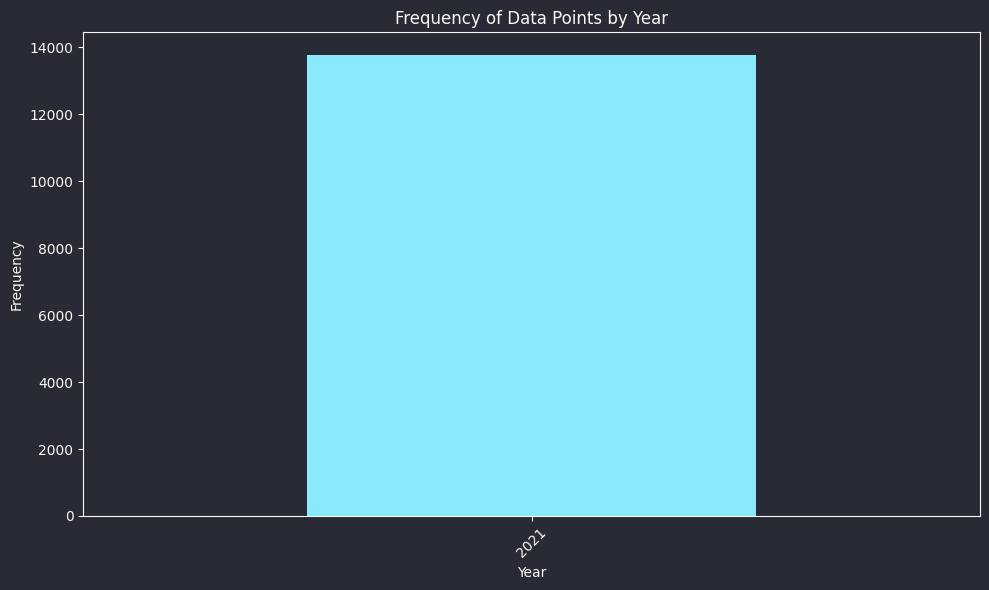

In [25]:
if 'date' in C_merged.columns:
    C_merged['date'] = pd.to_datetime(C_merged['date'], unit='s')
else:
    C_merged['date'] = pd.to_datetime(C_merged['month1'])

plt.figure(figsize=(10, 6))
C_merged['date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Data Points by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Month slice

In [28]:
# df = C_merged
# df['year_month'] = df['date'].dt.to_period('M')
# aggregated_df = df.groupby(['id', 'chain_name', 'token_name', 'year_month']).agg({'quantity': 'mean', 'value_usd': 'mean'}).reset_index()

# def query_by_month(year, month):
#     period = pd.Period(f"{year}-{month}", freq='M')
#     return aggregated_df[aggregated_df['year_month'] == period]

# result = query_by_month(2023, 7)

result = C_merged

In [29]:
result_sorted = result.sort_values(by='value_usd', ascending=False).head(3000)

# Check if token_name is not an integer string, then set the marker column to True
def is_not_integer_string(s):
    try:
        int(s)
        return False
    except ValueError:
        return True

result_sorted['non_listed_protocols'] = result_sorted['token_name'].apply(is_not_integer_string)

result_sorted['id'] = result_sorted['id'].astype(str)
result_sorted['token_name'] = result_sorted['token_name'].astype(str)
A['id'] = A['id'].astype(str)

# Create dictionaries for id to name and id to url mapping from A
id_to_name = pd.Series(A['name'].values, index=A['id']).to_dict()
id_to_url = pd.Series(A['url'].values, index=A['id']).to_dict()

# Apply mapping for destination_node, use 'id' as default if 'id' not found in 'id_to_name'
result_sorted['destination_node'] = result_sorted['id'].apply(lambda x: id_to_name.get(x, x))

# Apply mapping for source_node, use 'token_name' as default if 'token_name' not found in 'id_to_name'
result_sorted['source_node'] = result_sorted['token_name'].apply(lambda x: id_to_name.get(x, x))

# Apply mapping to get 'url', default to None or a placeholder if 'id' not found
result_sorted['url'] = result_sorted['id'].apply(lambda x: id_to_url.get(x, None))

KeyError: 'value_usd'

In [350]:
from pyvis.network import Network
import pandas as pd

# Initialize Pyvis network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#FFFFFF", font_color="black", directed=True, cdn_resources="in_line")

# Track all unique nodes to avoid duplication
unique_nodes = set()

# Add nodes and edges
for index, row in result_sorted.iterrows():
    source_node = row['source_node']
    destination_node = row['destination_node']
    url = row['url']
    non_listed_protocols = row['non_listed_protocols']  # Assuming this column exists in result_sorted
    
    # Determine node color based on non_listed_protocols
    node_color = "#ffb71a" if not non_listed_protocols else "#ff4b4b"
    
    # Add nodes if they haven't been added yet
    if source_node not in unique_nodes:
        net.add_node(source_node, label=source_node, title=f"<a href='{url}' target='_blank'>{source_node}</a>", color=node_color)
        unique_nodes.add(source_node)
    if destination_node not in unique_nodes:
        net.add_node(destination_node, label=destination_node, title=f"<a href='{url}' target='_blank'>{destination_node}</a>", color=node_color)
        unique_nodes.add(destination_node)
    
    # Add directed edge with value_usd as title for hover details
    edge_width = row['value_usd'] / max(result_sorted['value_usd']) * 10  # Scale for visibility
    net.add_edge(source_node, destination_node, title=f"USD: ${row['value_usd']:.2f}", width=edge_width, arrows="to")

# net.add_node("DeFi Protocol", label="DeFi Protocol", color="#ffb71a", title="DeFi Protocols", shape='box')
# net.add_node("Non-DeFi Protocol", label="Non-DeFi Protocol", color="#ff4b4b", title="Non-DeFi Protocols", shape='box')

net.set_options("""
{
  "nodes": {
    "font": {
      "size": 24
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "centralGravity": 0.005,
      "springLength": 100,
      "springConstant": 0.05,
      "damping": 0.9
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based",
    "timestep": 0.35,
    "stabilization": {
      "enabled": true,
      "iterations": 1000,
      "updateInterval": 25,
      "onlyDynamicEdges": true,
      "fit": true
    }
  }
}
""")

# Show the network
net.show("month_slice_network.html")

month_slice_network.html


## Month changes

In [340]:
def compare_months(C_merged, year1, month1, year2, month2):
    # Convert 'date' to 'year_month' format for easier comparison
    C_merged['year_month'] = C_merged['date'].dt.to_period('M')
    
    # Aggregate data by month
    aggregated_df = C_merged.groupby(['id', 'chain_name', 'token_name', 'year_month']).agg({'quantity': 'mean', 'value_usd': 'mean'}).reset_index()
    
    # Filter data for the two specific months
    data_month1 = aggregated_df[aggregated_df['year_month'] == pd.Period(f"{year1}-{month1}", freq='M')]
    data_month2 = aggregated_df[aggregated_df['year_month'] == pd.Period(f"{year2}-{month2}", freq='M')]
    
    # Merge the two datasets on 'id', 'chain_name', and 'token_name'
    merged_data = pd.merge(data_month1, data_month2, on=['id', 'chain_name', 'token_name'], how='outer', suffixes=('_month1', '_month2'))
    
    # Filter out rows that do not have entries in both months
    valid_data = merged_data.dropna(subset=['month1', 'month2'])
    
    # Calculate the differences
    valid_data['qty_change'] = valid_data['quantity_month2'] - valid_data['quantity_month1']
    valid_data['usd_change'] = valid_data['value_usd_month2'] - valid_data['value_usd_month1']
    
    # Filter rows where there are no changes
    changed_data = valid_data[(valid_data['qty_change'] != 0) | (valid_data['usd_change'] != 0)]
    
    # Select relevant columns to display
    result = changed_data[['id', 'chain_name', 'token_name', 'month1', 'month2', 'qty_change', 'usd_change']]
    
    return result

# Example usage: Compare changes from June 2023 to July 2023
result_changes = compare_months(C_merged, 2023, 6, 2023, 7)

/var/folders/f0/djj7fhr557g00t074rkmzmrr0000gn/T/ipykernel_7763/811858585.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['quantity_change'] = valid_data['quantity_month2'] - valid_data['quantity_month1']
/var/folders/f0/djj7fhr557g00t074rkmzmrr0000gn/T/ipykernel_7763/811858585.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['value_usd_change'] = valid_data['value_usd_month2'] - valid_data['value_usd_month1']


In [30]:
result_changes = C_merged

In [31]:
changes_sorted = result_changes.sort_values(by='usd_change', ascending=False)
result_sorted = pd.concat([changes_sorted.head(1500), changes_sorted.tail(1500)])

def is_not_integer_string(s):
    try:
        int(s)
        return False
    except ValueError:
        return True

result_sorted['non_listed_protocols'] = result_sorted['token_name'].apply(is_not_integer_string)

result_sorted['id'] = result_sorted['id'].astype(str)
result_sorted['token_name'] = result_sorted['token_name'].astype(str)
A['id'] = A['id'].astype(str)

# Create dictionaries for id to name and id to url mapping from A
id_to_name = pd.Series(A['name'].values, index=A['id']).to_dict()
id_to_url = pd.Series(A['url'].values, index=A['id']).to_dict()

# Apply mapping for destination_node, use 'id' as default if 'id' not found in 'id_to_name'
result_sorted['destination_node'] = result_sorted['id'].apply(lambda x: id_to_name.get(x, x))

# Apply mapping for source_node, use 'token_name' as default if 'token_name' not found in 'id_to_name'
result_sorted['source_node'] = result_sorted['token_name'].apply(lambda x: id_to_name.get(x, x))

# Apply mapping to get 'url', default to None or a placeholder if 'id' not found
result_sorted['url'] = result_sorted['id'].apply(lambda x: id_to_url.get(x, None))

In [32]:
from pyvis.network import Network
import pandas as pd

# Initialize Pyvis network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#FFFFFF", font_color="black", directed=True, cdn_resources="in_line")

# Track all unique nodes to avoid duplication
unique_nodes = set()

# Add nodes and edges
for index, row in result_sorted.iterrows():
    source_node = row['source_node']
    destination_node = row['destination_node']
    url = row['url']
    non_listed_protocols = row['non_listed_protocols']
    usd_change = row['usd_change']  # Assuming this column exists in result_sorted
    
    # Determine node color based on non_listed_protocols
    node_color = "#ffb71a" if not non_listed_protocols else "#ff4b4b"
    
    # Reverse the edge direction if usd_change is negative
    if usd_change < 0:
        source_node, destination_node = destination_node, source_node
    
    # Add nodes if they haven't been added yet
    if source_node not in unique_nodes:
        net.add_node(source_node, label=source_node, title=f"<a href='{url}' target='_blank'>{source_node}</a>", color=node_color)
        unique_nodes.add(source_node)
    if destination_node not in unique_nodes:
        net.add_node(destination_node, label=destination_node, title=f"<a href='{url}' target='_blank'>{destination_node}</a>", color=node_color)
        unique_nodes.add(destination_node)
    
    # Add directed edge with value_usd as title for hover details
    edge_width = abs(row['usd_change']) / max(abs(result_sorted['usd_change'])) * 10  # Scale for visibility
    net.add_edge(source_node, destination_node, title=f"USD Change: ${row['usd_change']:.2f}", width=edge_width, arrows="to")

net.set_options("""
{
  "nodes": {
    "font": {
      "size": 24
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "centralGravity": 0.005,
      "springLength": 100,
      "springConstant": 0.05,
      "damping": 0.9
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based",
    "timestep": 0.35,
    "stabilization": {
      "enabled": true,
      "iterations": 1000,
      "updateInterval": 25,
      "onlyDynamicEdges": true,
      "fit": true
    }
  }
}
""")

# Show the network
net.show("month_change_network.html")

month_change_network.html


# Final Integration

In [ ]:
from config.query import BigQueryClient
from config.config import TABLES
from config.plotting_network import NetworkVisualizer

bq = BigQueryClient()
A = bq.get_dataframe(TABLES['A'])
C = bq.compare_months('2021', '7', '2021', '8')

categorizer = NetworkVisualizer(C)
result = categorizer.process(A)
html_content = categorizer.plot_network(result)

file_path = 'test.html'
with open(file_path, 'w') as file:
    file.write(html_content)

### Preliminaries

Let:

- \( \mathcal{A} \) represent the set of all protocols, where each protocol \( a \in \mathcal{A} \) is identified by a unique identifier \( id_a \), and may have associated attributes such as name and URL.
- \( \mathcal{C} \) denote the set of time-based data entries, where each entry \( c \in \mathcal{C} \) corresponds to a token and includes information on the token's name, the change in its locked value over a specified time interval, and possibly its association with a protocol in \( \mathcal{A} \).

### Categorization Function

Define a categorization function \( \phi: \mathcal{C} \rightarrow \mathcal{K} \), which maps each token \( c \) to a category \( k \in \mathcal{K} = \{ \text{rev\_map}, \text{LP}, \text{UNKNOWN}, \text{Other} \} \) based on predefined rules related to the token's name and presence in reverse mappings or lists.

### Processing Functions

1. **Unknown Tokens Processing** \( \psi_{\text{UNKNOWN}}: \mathcal{C}_{\text{UNKNOWN}} \rightarrow \mathcal{A} \): For tokens categorized as UNKNOWN, this function attempts to match token names to Ethereum addresses and subsequently to protocol identifiers in \( \mathcal{A} \), effectively refining \( \mathcal{C}_{\text{UNKNOWN}} \) to a more identifiable subset of \( \mathcal{A} \).

2. **Other Tokens Processing** \( \psi_{\text{Other}}: \mathcal{C}_{\text{Other}} \rightarrow \mathcal{A} \cup \{ \text{null} \} \): Applies manual mappings and filters to tokens in the Other category, potentially mapping them to protocols in \( \mathcal{A} \) or excluding them (mapped to null).

3. **Reverse Mapping Application** \( \psi_{\text{rev\_map}}: \mathcal{C}_{\text{rev\_map}} \rightarrow \mathcal{A} \): Directly maps tokens in the rev_map category to protocols in \( \mathcal{A} \) using the provided reverse mapping.

### Merging and Sorting

After processing, the subsets of \( \mathcal{C} \) are merged into a single set \( \mathcal{C}_{\text{merged}} \), which is then sorted based on the magnitude of value change, resulting in \( \mathcal{C}_{\text{sorted}} \).

### Graph Construction

Construct a directed graph \( G = (V, E) \) where:

- \( V \) corresponds to protocols in \( \mathcal{A} \), with each node \( v \) representing a protocol.
- \( E \) consists of directed edges between nodes in \( V \), with each edge \( e(v_i, v_j) \) representing the flow of value from protocol \( v_i \) to protocol \( v_j \), derived from \( \mathcal{C}_{\text{sorted}} \). The weight of each edge is proportional to the magnitude of the value change.

### Visualization

The visualization of \( G \) aims to depict the dynamics of value flow across protocols, highlighting significant interactions and changes within the ecosystem. Node and edge attributes (e.g., color, width) are used to convey additional information, such as the categorization of protocols and the magnitude of value changes.

This abstract and mathematical description encapsulates the process from data categorization through to the construction and visualization of the network graph, providing a comprehensive overview of the methodology employed.